# CYBERML - Project

## Importation du dataset

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

In [2]:
# file1_path = "../SWaT.A7_June 2020/22June2020 (1).xlsx"
# file2_path = "../SWaT.A7_June 2020/22June2020 (2).xlsx"
# file3_path = "../SWaT.A7_June 2020/29June2020 (1).xlsx"
# file4_path = "../SWaT.A7_June 2020/29June2020 (2).xlsx"

# df1 = pd.read_excel(file1_path)
# df2 = pd.read_excel(file2_path)
# df3 = pd.read_excel(file3_path, usecols=range(61))
# df4 = pd.read_excel(file4_path)
# print(df1.shape)
# print(df2.shape)
# print(df3.shape)
# print(df4.shape)

In [3]:
# print(df1.columns.to_list())
# print(df2.columns.to_list())
# print(df3.columns.to_list())
# print(df4.columns.to_list())

In [4]:
# common_columns = list(set(df1.columns) & set(df2.columns) & set(df3.columns) & set(df4.columns))
# # columns in df1 but not in common_columns
# missing_columns = list(set(df1.columns) - set(common_columns))
# print(missing_columns)
# print(len(missing_columns))
# print(len(common_columns))

# print(f"Missing columns : {list(set(df1.columns) ^ set(df2.columns) ^ set(df3.columns) ^ set(df4.columns))}")

In [5]:
# df1 = df1[common_columns]
# df2 = df2[common_columns]
# df3 = df3[common_columns]
# df4 = df4[common_columns]
# print(df1.columns.to_list())
# print(df2.columns.to_list())
# print(df3.columns.to_list())
# print(df4.columns.to_list())

In [6]:
# if list(df1.columns) != list(df2.columns) or list(df1.columns) != list(df3.columns) or list(df1.columns) != list(df4.columns):
#     print("Les colonnes des deux fichiers ne correspondent pas.")
#     print("Colonnes dans le fichier 1 :", df1.columns)
#     print("Colonnes dans le fichier 2 :", df2.columns)
#     print("Colonnes dans le fichier 3 :", df3.columns)
#     print("Colonnes dans le fichier 4 :", df4.columns)
# else:
#     print("Les colonnes des deux fichiers correspondent.")
#     df_combined = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

#     # Vérifier le nombre de lignes et de colonnes du dataset combiné
#     print(f"Dataset combiné : {df_combined.shape} lignes et colonnes")

#     # Sauvegarder le dataset combiné dans un fichier CSV
#     output_path = "../SWaT.A7_June 2020/df_combined.csv"
#     df_combined.to_csv(output_path, index=False)

#     print(f"Dataset fusionné sauvegardé dans : {output_path}")

In [7]:
df = pd.read_csv("../SWaT.A7_June 2020/df_combined.csv", low_memory=False)

In [8]:
df.shape

(32402, 61)

In [9]:
df.tail()

,FIT503.Pv,FIT501.Pv,P402.Status,AIT202.Pv,MV201.Status,P4_STATE,P601.Status,PIT503.Pv,P102.Status,P203.Status,...,AIT504.Pv,AIT401.Pv,MV303.Status,LIT401.Pv,P404.Status,PIT501.Pv,P6_STATE,FIT601.Pv,t_stamp,P1_STATE
32397,0.1138175,1.34324539,1,8.310562,2,4,1,202.656372,1,2,...,0.692130199999999,0,1,924.07074,1,228.547164999999,2,0.000320379331,2020-06-29 15:29:56,3
32398,0.1138175,1.34478343,1,8.307037,2,4,1,202.656372,1,2,...,0.692130199999999,0,1,924.455261,1,228.547164999999,2,0.000320379331,2020-06-29 15:29:57,3
32399,0.1138175,1.34632146,1,8.303833,2,4,1,202.656372,1,2,...,0.692130199999999,0,1,924.4937,1,228.547164999999,2,0.000320379331,2020-06-29 15:29:58,3
32400,0.1138175,1.34632146,1,8.30191,2,4,1,202.656372,1,2,...,0.692130199999999,0,1,924.4168,1,228.547164999999,2,0.000320379331,2020-06-29 15:29:59,3
32401,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,...,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,Bad Input,2020-06-29 15:30:00,Bad Input


In [10]:
df = df.drop(df.tail(1).index)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32401 entries, 0 to 32400
Data columns (total 61 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   FIT503.Pv     32401 non-null  object
 1   FIT501.Pv     32401 non-null  object
 2   P402.Status   32401 non-null  object
 3   AIT202.Pv     32401 non-null  object
 4   MV201.Status  32401 non-null  object
 5   P4_STATE      32401 non-null  object
 6   P601.Status   32401 non-null  object
 7   PIT503.Pv     32401 non-null  object
 8   P102.Status   32401 non-null  object
 9   P203.Status   32401 non-null  object
 10  P302.Status   32401 non-null  object
 11  MV301.Status  32401 non-null  object
 12  MV302.Status  32401 non-null  object
 13  FIT502.Pv     32401 non-null  object
 14  FIT504.Pv     32401 non-null  object
 15  FIT201.Pv     32401 non-null  object
 16  DPIT301.Pv    32401 non-null  object
 17  AIT402.Pv     32401 non-null  object
 18  P201.Status   32401 non-null  object
 19  P3_S

In [12]:
df.describe()

,FIT503.Pv,FIT501.Pv,P402.Status,AIT202.Pv,MV201.Status,P4_STATE,P601.Status,PIT503.Pv,P102.Status,P203.Status,...,AIT504.Pv,AIT401.Pv,MV303.Status,LIT401.Pv,P404.Status,PIT501.Pv,P6_STATE,FIT601.Pv,t_stamp,P1_STATE
count,32401,32401,32401,32401,32401,32401,32401,32401,32401,32401,...,32401,32401,32401,32401,32401,32401,32401,32401,32401,32401
unique,127,723,1,5838,3,4,2,781,1,2,...,358,1,3,7873,1,799,2,169,32401,3
top,0.00217648758999999,0.00230710068999999,1,9.640348,1,4,1,7.8345294,1,1,...,1.69187391,0,1,1006.20355,1,12.352602,2,0.000256303465,2020-06-22 10:00:00,2
freq,6936,4657,32401,49,17205,27881,25873,938,32401,17765,...,2914,32401,31955,296,32401,1474,27785,23697,1,15255


In [13]:
df.isnull().sum()

FIT503.Pv       0
FIT501.Pv       0
P402.Status     0
AIT202.Pv       0
MV201.Status    0
               ..
PIT501.Pv       0
P6_STATE        0
FIT601.Pv       0
t_stamp         0
P1_STATE        0
Length: 61, dtype: int64

In [14]:
pd.set_option('display.max_columns', None)
df.columns

Index(['FIT503.Pv', 'FIT501.Pv', 'P402.Status', 'AIT202.Pv', 'MV201.Status',
       'P4_STATE', 'P601.Status', 'PIT503.Pv', 'P102.Status', 'P203.Status',
       'P302.Status', 'MV301.Status', 'MV302.Status', 'FIT502.Pv', 'FIT504.Pv',
       'FIT201.Pv', 'DPIT301.Pv', 'AIT402.Pv', 'P201.Status', 'P3_STATE',
       'FIT401.Pv', 'AIT501.Pv', 'MV503.Status', 'MV501.Status', 'AIT503.Pv',
       'MV504.Status', 'P2_STATE', 'P401.Status', 'P602.Status',
       'UV401.Status', 'P204.Status', 'P5_STATE', 'LIT101.Pv', 'P205.Status',
       'AIT502.Pv', 'MV101.Status', 'P206.Status', 'P101.Status', 'AIT203.Pv',
       'FIT101.Pv', 'P301.Status', 'PIT502.Pv', 'P502.Status', 'MV502.Status',
       'MV304.Status', 'P202.Status', 'P403.Status', 'AIT201.Pv', 'FIT301.Pv',
       'P501.Status', 'LIT301.Pv', 'AIT504.Pv', 'AIT401.Pv', 'MV303.Status',
       'LIT401.Pv', 'P404.Status', 'PIT501.Pv', 'P6_STATE', 'FIT601.Pv',
       't_stamp', 'P1_STATE'],
      dtype='object')

In [15]:
cols_numeric = cols_to_convert = df.columns.difference(['t_stamp'])
df[cols_numeric] = df[cols_numeric].apply(pd.to_numeric, errors='coerce')

In [16]:
df.describe()

,FIT503.Pv,FIT501.Pv,P402.Status,AIT202.Pv,MV201.Status,P4_STATE,P601.Status,PIT503.Pv,P102.Status,P203.Status,P302.Status,MV301.Status,MV302.Status,FIT502.Pv,FIT504.Pv,FIT201.Pv,DPIT301.Pv,AIT402.Pv,P201.Status,P3_STATE,FIT401.Pv,AIT501.Pv,MV503.Status,MV501.Status,AIT503.Pv,MV504.Status,P2_STATE,P401.Status,P602.Status,UV401.Status,P204.Status,P5_STATE,LIT101.Pv,P205.Status,AIT502.Pv,MV101.Status,P206.Status,P101.Status,AIT203.Pv,FIT101.Pv,P301.Status,PIT502.Pv,P502.Status,MV502.Status,MV304.Status,P202.Status,P403.Status,AIT201.Pv,FIT301.Pv,P501.Status,LIT301.Pv,AIT504.Pv,AIT401.Pv,MV303.Status,LIT401.Pv,P404.Status,PIT501.Pv,P6_STATE,FIT601.Pv,P1_STATE
count,32401.000000,32401.000000,32401.0,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.0,32401.000000,32401.0,32401.000000,32401.000000,32401.000000,3.240100e+04,32401.000000,32401.000000,32401.0,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.0,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.0,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.0,32401.000000,32401.000000,32401.0,32401.0,32401.000000,32401.000000,32401.000000,32401.000000,32401.000000,32401.0,32401.000000,32401.000000,32401.0,32401.000000,32401.000000,32401.000000,32401.000000
mean,0.079532,0.914571,1.0,8.194726,1.460912,3.582852,1.201475,144.649416,1.0,1.451714,1.0,1.002346,1.476930,0.811564,1.976956e-09,1.074940,9.576453,0.0,1.452949,22.767013,0.908588,7.449547,1.012654,1.745563,49.987819,1.016111,1.857535,1.687571,1.003796,1.687016,1.0,9.317737,706.582982,1.452949,187.615877,1.077467,1.0,1.464523,137.982741,0.379398,1.496281,4.201728,1.0,1.742261,1.015432,1.0,1.0,45.386451,0.975057,1.677757,845.996820,2.353729,0.0,1.010617,820.972442,1.0,163.622218,1.857535,0.007407,2.244313
std,0.052184,0.615571,0.0,0.898582,0.506524,1.037058,0.401108,87.528900,0.0,0.497671,0.0,0.076138,0.509448,0.546496,3.558575e-07,1.162023,6.394101,0.0,0.497789,37.067503,0.612760,0.168996,0.131094,0.438024,14.983966,0.141377,0.349532,0.463491,0.061497,0.463715,0.0,4.738990,91.963925,0.497789,41.320929,0.276751,0.0,0.498747,29.933342,1.207699,0.499994,5.205404,0.0,0.440350,0.164080,0.0,0.0,33.332024,0.982041,0.467343,163.521480,4.103129,0.0,0.116845,221.859677,0.0,97.268480,0.349532,0.107344,0.685206
min,0.001408,0.001025,1.0,6.525122,0.000000,1.000000,1.000000,7.786465,1.0,1.000000,1.0,0.000000,0.000000,0.000640,0.000000e+00,0.000000,0.016006,0.0,1.000000,1.000000,0.000000,7.177519,0.000000,0.000000,28.101768,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,489.913666,1.000000,146.936676,0.000000,1.0,1.000000,13.919508,0.000000,1.000000,0.160190,1.0,0.000000,0.000000,1.0,1.0,6.729044,0.000000,1.000000,274.569031,0.038452,0.0,0.000000,244.245071,1.0,12.176365,1.000000,0.000000,1.000000
25%,0.002176,0.002563,1.0,7.469751,1.000000,4.000000,1.000000,24.032299,1.0,1.000000,1.0,1.000000,1.000000,0.001921,0.000000e+00,0.000256,3.498944,0.0,1.000000,1.000000,0.000512,7.288067,1.000000,1.000000,41.848244,1.000000,2.000000,1.000000,1.000000,1.000000,1.0,8.000000,614.070100,1.000000,160.779282,1.000000,1.0,1.000000,130.069214,0.000000,1.000000,2.018390,1.0,1.000000,1.000000,1.0,1.0,18.072288,0.000641,1.000000,794.267500,1.499615,0.0,1.000000,808.369600,1.0,28.566393,2.000000,0.000256,2.000000
50%,0.113305,1.313125,1.0,8.151628,1.000000,4.000000,1.000000,199.532166,1.0,1.000000,1.0,1.000000,1.000000,1.159857,0.000000e+00,0.000384,3.787054,0.0,1.000000,7.000000,1.306486,7.469110,1.000000,2.000000,47.007180,1.000000,2.000000,2.000000,1.000000,2.000000,1.0,12.000000,718.443237,1.000000,168.367081,1.000000,1.0,1.000000,139.861572,0.000000,1.000000,2.098485,1.0,2.000000,1.000000,1.0,1.0,37.426300,0.467988,2.000000,879.942700,1.884132,0.0,1.000000,894.539856,1.0,225.310822,2.000000,0.000256,2.000000
75%,0.115866,1.340041,1.0,9.047873,2.000000,4.000000,1.000000,205.7

In [17]:
df.dtypes

FIT503.Pv       float64
FIT501.Pv       float64
P402.Status       int64
AIT202.Pv       float64
MV201.Status      int64
                 ...   
PIT501.Pv       float64
P6_STATE          int64
FIT601.Pv       float64
t_stamp          object
P1_STATE          int64
Length: 61, dtype: object

### Pré-traitement des données

In [18]:
df = df.dropna()
df.isnull().sum()

FIT503.Pv       0
FIT501.Pv       0
P402.Status     0
AIT202.Pv       0
MV201.Status    0
               ..
PIT501.Pv       0
P6_STATE        0
FIT601.Pv       0
t_stamp         0
P1_STATE        0
Length: 61, dtype: int64

In [19]:
columns_to_encode = [column for column in df.columns if df[column].nunique() < 20]
print(columns_to_encode)
print(len(columns_to_encode))

['P402.Status', 'MV201.Status', 'P4_STATE', 'P601.Status', 'P102.Status', 'P203.Status', 'P302.Status', 'MV301.Status', 'MV302.Status', 'FIT504.Pv', 'AIT402.Pv', 'P201.Status', 'P3_STATE', 'MV503.Status', 'MV501.Status', 'MV504.Status', 'P2_STATE', 'P401.Status', 'P602.Status', 'UV401.Status', 'P204.Status', 'P5_STATE', 'P205.Status', 'MV101.Status', 'P206.Status', 'P101.Status', 'P301.Status', 'P502.Status', 'MV502.Status', 'MV304.Status', 'P202.Status', 'P403.Status', 'P501.Status', 'AIT401.Pv', 'MV303.Status', 'P404.Status', 'P6_STATE', 'P1_STATE']
38


In [20]:
df = pd.get_dummies(df, drop_first=True, columns=columns_to_encode)

In [21]:
df['t_stamp'] = pd.to_datetime(df['t_stamp'], format='mixed')
df_22 = df[df['t_stamp'].dt.day == 22].copy()
df_29 = df[df['t_stamp'].dt.day == 29].copy()
start_time_29 = df_29['t_stamp'].min()
end_time_29 = df_29['t_stamp'].max()
start_time_22 = df_22['t_stamp'].min()
end_time_22 = df_22['t_stamp'].max()
print(f"22nd of June started at : {start_time_22} and ended at : {end_time_22}")
print(f"29th of June started at : {start_time_29} and ended at : {end_time_29}")

22nd of June started at : 2020-06-22 09:00:00 and ended at : 2020-06-22 14:01:10.990000
29th of June started at : 2020-06-29 10:00:00 and ended at : 2020-06-29 15:29:59


In [22]:
df_22.set_index('t_stamp', inplace=True)
df_29.set_index('t_stamp', inplace=True)

In [23]:
scaler = StandardScaler()
df_22_scaled = scaler.fit_transform(df_22)
df_22_scaled = pd.DataFrame(df_22_scaled, columns=df_22.columns)
df_29_scaled = scaler.fit_transform(df_29)
df_29_scaled = pd.DataFrame(df_29_scaled, columns=df_29.columns)
df_scaled = pd.concat([df_22_scaled, df_29_scaled], axis=0)
df_scaled.head()

,FIT503.Pv,FIT501.Pv,AIT202.Pv,PIT503.Pv,FIT502.Pv,FIT201.Pv,DPIT301.Pv,FIT401.Pv,AIT501.Pv,AIT503.Pv,LIT101.Pv,AIT502.Pv,AIT203.Pv,FIT101.Pv,PIT502.Pv,AIT201.Pv,FIT301.Pv,LIT301.Pv,AIT504.Pv,LIT401.Pv,PIT501.Pv,FIT601.Pv,MV201.Status_1,MV201.Status_2,P4_STATE_2,P4_STATE_3,P4_STATE_4,P601.Status_2,P203.Status_2,MV301.Status_1,MV301.Status_2,MV302.Status_1,MV302.Status_2,FIT504.Pv_6.405534e-05,P201.Status_2,P3_STATE_2,P3_STATE_4,P3_STATE_5,P3_STATE_6,P3_STATE_7,P3_STATE_9,P3_STATE_10,P3_STATE_12,P3_STATE_13,P3_STATE_14,P3_STATE_15,P3_STATE_16,P3_STATE_99,MV503.Status_1,MV503.Status_2,MV501.Status_1,MV501.Status_2,MV504.Status_1,MV504.Status_2,P2_STATE_2,P401.Status_2,P602.Status_2,UV401.Status_2,P5_STATE_3,P5_STATE_4,P5_STATE_5,P5_STATE_6,P5_STATE_8,P5_STATE_9,P5_STATE_10,P5_STATE_11,P5_STATE_12,P5_STATE_13,P5_STATE_15,P5_STATE_16,P5_STATE_17,P5_STATE_18,P5_STATE_19,P5_STATE_21,P205.Status_2,MV101.Status_1,MV101.Status_2,P101.Status_2,P301.Status_2,MV502.Status_1,MV502.Status_2,MV304.Status_1,MV304.Status_2,P501.Status_2,MV303.Status_1,MV303.Status_2,P6_STATE_2,P1_STATE_2,P1_STATE_3
0,0.704228,0.680738,-0.755583,0.706508,0.710634,-0.806364,-1.022033,0.683918,0.332407,-0.396841,-0.382391,-0.783706,0.155874,-0.217778,0.024663,-0.749154,-1.053379,0.967036,-0.107304,-0.400634,0.70593,-0.077618,0.813004,-0.805578,-0.023577,-0.01826,0.12774,-0.482048,-0.799777,0.089172,-0.074367,1.021112,-1.010387,0.0,-0.799777,-0.046598,-0.110723,-0.060201,-0.061124,-1.001557,-0.038759,-0.039471,-0.071675,-0.007454,-0.039471,-0.040859,-0.087897,-0.433998,0.155693,-0.144268,-0.520583,0.522996,0.169205,-0.159946,0.150948,0.69811,-0.072066,0.699166,-0.033352,-0.10438,-0.007454,-0.056856,-0.031639,-0.033352,-0.033352,-0.030746,0.535639,-0.040171,-0.031639,-0.032506,-0.033352,-0.031639,-0.06425,-0.023577,-0.799777,0.218192,-0.215948,-0.804828,-1.041296,-0.527043,0.529881,0.176533,-0.157184,0.71934,0.13771,-0.129303,0.150948,-1.847682,1.973313
1,0.704228,0.680738,-0.761180,0.706508,0.712522,-0.806364,-1.022033,0.683918,0.299725,-0.396841,-0.384191,-0.783706,0.155874,-0.217778,0.024663,-0.748193,-1.053379,0.967036,-0.107304,-0.401956,0.70593,-0.077618,0.813004,-0.805578,-0.023577,-0.01826,0.12774,-0.482048,-0.799777,0.089172,-0.074367,1.021112,-1.010387,0.0,-0.799777,-0.046598,-0.110723,-0.060201,-0.061124,-1.001557,-0.038759,-0.039471,-0.071675,-0.007454,-0.039471,-0.040859,-0.087897,-0.433998,0.155693,-0.144268,-0.520583,0.522996,0.169205,-0.159946,0.150948,0.69811,-0.072066,0.699166,-0.033352,-0.10438,-0.007454,-0.056856,-0.031639,-0.033352,-0.033352,-0.030746,0.535639,-0.040171,-0.031639,-0.032506,-0.033352,-0.031639,-0.06425,-0.023577,-0.799777,0.218192,-0.215948,-0.804828,-1.041296,-0.527043,0.529881,0.176533,-0.157184,0.71934,0.13771,-0.129303,0.150948,-1.847682,1.973313
2,0.704228,0.680738,-0.767895,0.706508,0.712522,-0.806364,-1.022033,0.683918,0.299725,-0.396841,-0.386441,-0.783706,0.155874,-0.217778,0.024663,-0.748193,-1.053379,0.967036,-0.107304,-0.402544,0.70593,-0.077618,0.813004,-0.805578,-0.023577,-0.01826,0.12774,-0.482048,-0.799777,0.089172,-0.074367,1.021112,-1.010387,0.0,-0.799777,-0.046598,-0.110723,-0.060201,-0.061124,-1.001557,-0.038759,-0.039471,-0.071675,-0.007454,-0.039471,-0.040859,-0.087897,-0.433998,0.155693,-0.144268,-0.520583,0.522996,0.169205,-0.159946,0.150948,0.69811,-0.072066,0.699166,-0.033352,-0.10438,-0.007454,-0.056856,-0.031639,-0.033352,-0.033352,-0.030746,0.535639,-0.040171,-0.031639,-0.032506,-0.033352,-0.031639,-0.06425,-0.023577,-0.799777,0.218192,-0.215948,-0.804828,-1.041296,-0.527043,0.529881,0.176533,-0.157184,0.71934,0.13771,-0.129303,0.150948,-1.847682,1.973313
3,0.704228,0.680738,-0.772746,0.706508,0.724318,-0.806364,-1.022033,0.683918,0.299725,-0.396841,-0.386441,-0.789460,0.155874,-0.217778,0.024663,-0.748193,-1.053379,0.967036,-0.107304,-0.402838,0.70593,-0.077618,0.813004,-0.805578,-0.023577,-0.01826,0.12774,-0.482048,-0.799777,0.089172,-0.074367,1.021112,-1.010387,0.0,-0.799777,-0.046598,-0.110723,-0

## Option 1 : Anomaly Detection

### Isolation Forest

In [24]:
contamination = 0.02
duration = end_time_29 - start_time_29
print(f"We expect to be attacked for a duration of about {(contamination * duration).seconds} seconds")

model = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)

model.fit(df_22_scaled)
df_29.loc[:, "Anomalie"] = model.predict(df_29_scaled)
df_22.loc[:, "Anomalie"] = 1

df_if = pd.concat([df_22, df_29], axis=0)
df_if.head()

We expect to be attacked for a duration of about 395 seconds


,FIT503.Pv,FIT501.Pv,AIT202.Pv,PIT503.Pv,FIT502.Pv,FIT201.Pv,DPIT301.Pv,FIT401.Pv,AIT501.Pv,AIT503.Pv,LIT101.Pv,AIT502.Pv,AIT203.Pv,FIT101.Pv,PIT502.Pv,AIT201.Pv,FIT301.Pv,LIT301.Pv,AIT504.Pv,LIT401.Pv,PIT501.Pv,FIT601.Pv,MV201.Status_1,MV201.Status_2,P4_STATE_2,P4_STATE_3,P4_STATE_4,P601.Status_2,P203.Status_2,MV301.Status_1,MV301.Status_2,MV302.Status_1,MV302.Status_2,FIT504.Pv_6.405534e-05,P201.Status_2,P3_STATE_2,P3_STATE_4,P3_STATE_5,P3_STATE_6,P3_STATE_7,P3_STATE_9,P3_STATE_10,P3_STATE_12,P3_STATE_13,P3_STATE_14,P3_STATE_15,P3_STATE_16,P3_STATE_99,MV503.Status_1,MV503.Status_2,MV501.Status_1,MV501.Status_2,MV504.Status_1,MV504.Status_2,P2_STATE_2,P401.Status_2,P602.Status_2,UV401.Status_2,P5_STATE_3,P5_STATE_4,P5_STATE_5,P5_STATE_6,P5_STATE_8,P5_STATE_9,P5_STATE_10,P5_STATE_11,P5_STATE_12,P5_STATE_13,P5_STATE_15,P5_STATE_16,P5_STATE_17,P5_STATE_18,P5_STATE_19,P5_STATE_21,P205.Status_2,MV101.Status_1,MV101.Status_2,P101.Status_2,P301.Status_2,MV502.Status_1,MV502.Status_2,MV304.Status_1,MV304.Status_2,P501.Status_2,MV303.Status_1,MV303.Status_2,P6_STATE_2,P1_STATE_2,P1_STATE_3,Anomalie
t_stamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-22 10:00:00.000,0.116122,1.299282,7.519418,206.9982,1.165108,0.000256,3.441321,1.294193,7.615548,46.91105,695.284100,149.628300,135.708786,0.0,2.01839,18.072288,0.000641,1006.75311,1.845681,632.1841,232.376312,0.000256,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,True,True,False,True,False,True,1
2020-06-22 10:00:01.000,0.116122,1.299282,7.514612,206.9982,1.166133,0.000256,3.441321,1.294193,7.612343,46.91105,695.127100,149.628300,135.708786,0.0,2.01839,18.104332,0.000641,1006.75311,1.845681,631.8380,232.376312,0.000256,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,True,True,False,True,False,True,1
2020-06-22 10:00:02.005,0.116122,1.299282,7.508844,206.9982,1.166133,0.000256,3.441321,1.294193,7.612343,46.91105,694.930847,149.628300,135.708786,0.0,2.01839,18.104332,0.000641,1006.75311,1.845681,631.6842,232.376312,0.000256,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,True,True,False,True,False,True,1
2020-06-22 10:00:03.010,0.116122,1.299282,7.504678,206.9982,1.172537,0.000256,3.441321,1.294193,7.612343,46.91105,694.930847,149.525757,135.708786,0.0,2.01839,18.104332,0.000641,1006.75311,1.845681,631.6073,232.376312,0.000256,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,True,True,False,True,False,True,1
2020-06-22 10:00:04.015,0.116122,1.299282,7.498911,206.9982,1.169591,0.000256,3.441321,1.294193,7.611382,46.91105,694.852300,149.525757,135.708786,0.0,2.01839,18.104332,0.000641,1006.75311,1.845681,631.2997,232.376312,0.000256,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False

In [25]:
df_if['Anomalie_Label'] = df_if['Anomalie'].apply(lambda x: 'Normal' if x == 1 else 'Anomalie')
df_if['Anomalie_Label'].value_counts()

Anomalie_Label
Normal      32323
Anomalie       78
Name: count, dtype: int64

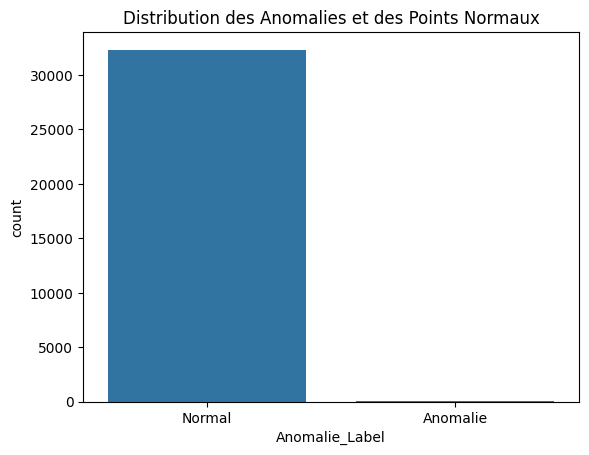

In [26]:
sns.countplot(x='Anomalie_Label', data=df_if)
plt.title("Distribution des Anomalies et des Points Normaux")
plt.show()

#### Some examples of easily separable data

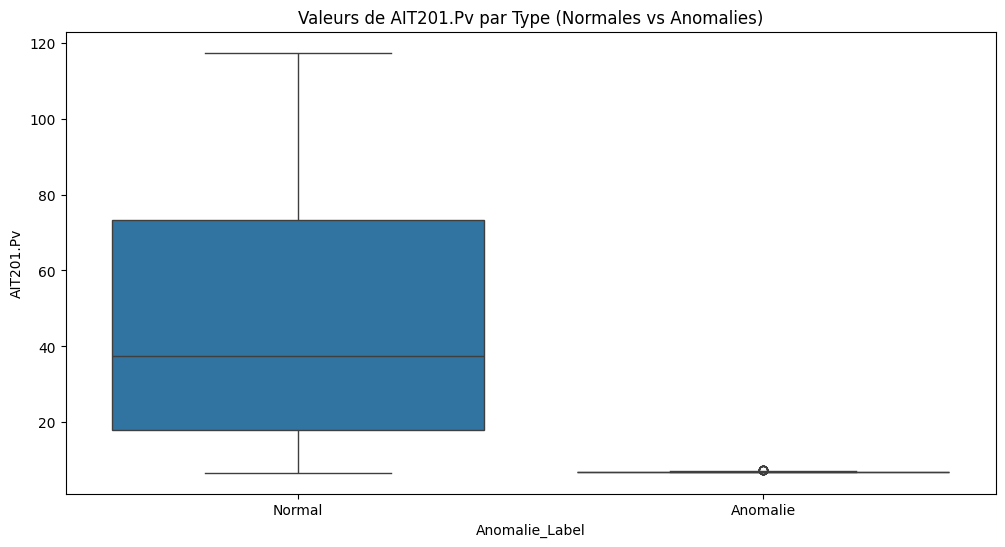

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Anomalie_Label', y='AIT201.Pv', data=df_if)
plt.title("Valeurs de AIT201.Pv par Type (Normales vs Anomalies)")
plt.show()

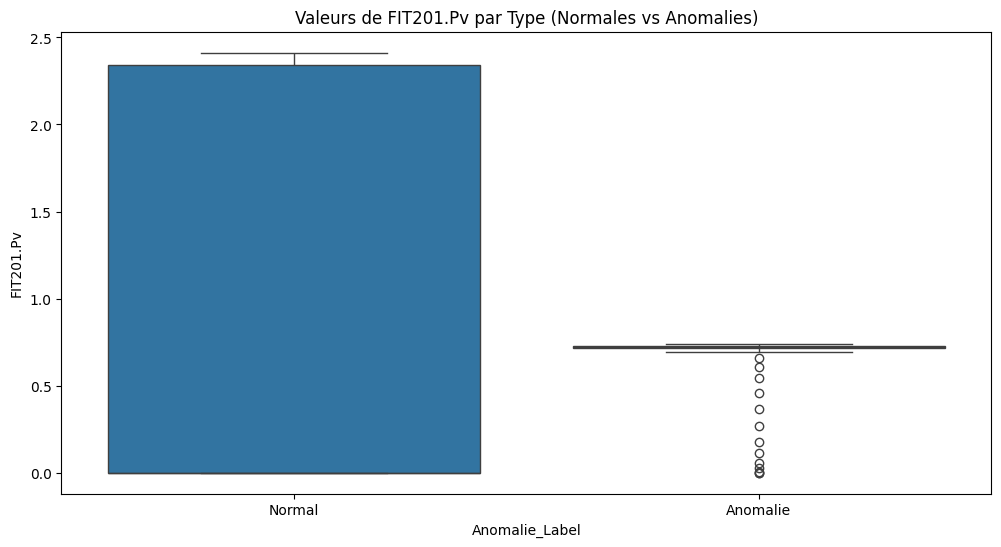

In [28]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Anomalie_Label', y='FIT201.Pv', data=df_if)
plt.title("Valeurs de FIT201.Pv par Type (Normales vs Anomalies)")
plt.show()

In [29]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled)

df_if['PCA1'] = reduced_data[:, 0]
df_if['PCA2'] = reduced_data[:, 1]

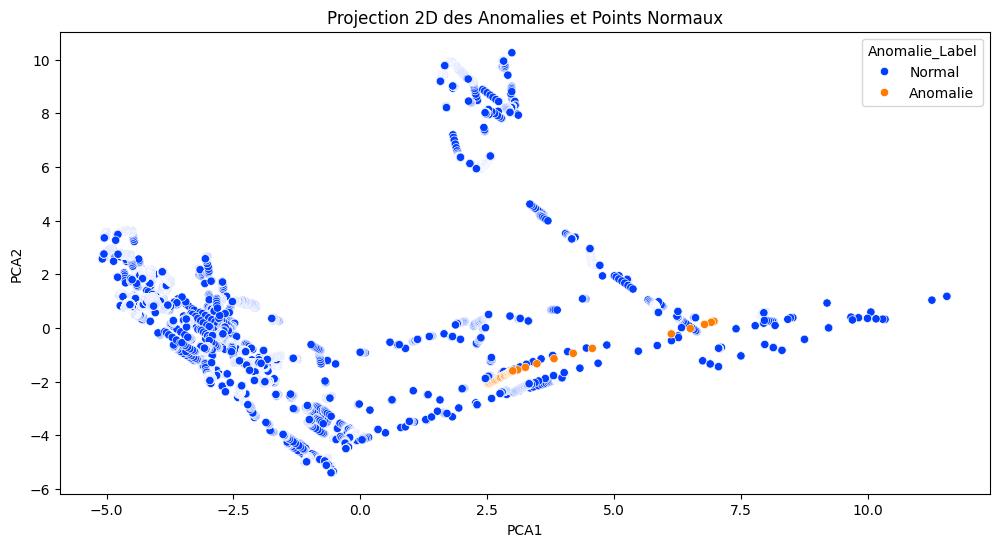

In [30]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Anomalie_Label', palette='bright', data=df_if)
plt.title("Projection 2D des Anomalies et Points Normaux")
plt.show()

### One Class SVM

In [31]:
svm = OneClassSVM(nu=0.02, kernel='rbf', gamma=0.001)
svm.fit(df_22_scaled)
df_29.loc[:, "Anomalie"] = svm.predict(df_29_scaled)
df_22.loc[:, "Anomalie"] = 1

df_svm = pd.concat([df_22, df_29], axis=0)
df_svm['Anomalie_Label'] = df_svm['Anomalie'].apply(lambda x: 'Normal' if x == 1 else 'Anomalie')
df_svm['Anomalie_Label'].value_counts()

Anomalie_Label
Normal      32179
Anomalie      222
Name: count, dtype: int64

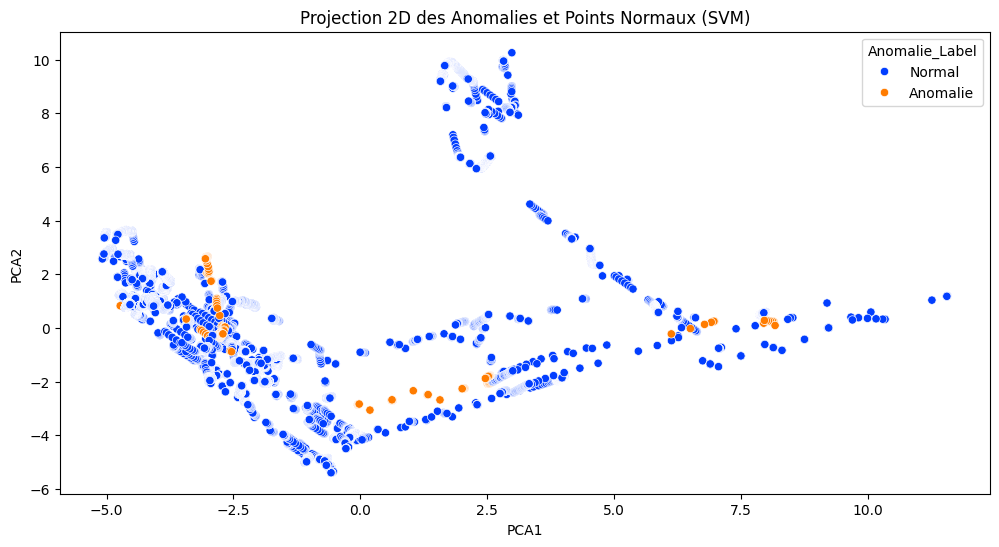

In [32]:
df_svm['PCA1'] = reduced_data[:, 0]
df_svm['PCA2'] = reduced_data[:, 1]

plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Anomalie_Label', palette='bright', data=df_svm)
plt.title("Projection 2D des Anomalies et Points Normaux (SVM)")
plt.show()

## Option 2 : Adversarial attacks against classification

### Random Forest

In [33]:
X = df_if.drop(columns=['Anomalie_Label'])
y = df_if['Anomalie_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

1.0


In [34]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Anomalie       1.00      1.00      1.00        17
      Normal       1.00      1.00      1.00      6464

    accuracy                           1.00      6481
   macro avg       1.00      1.00      1.00      6481
weighted avg       1.00      1.00      1.00      6481



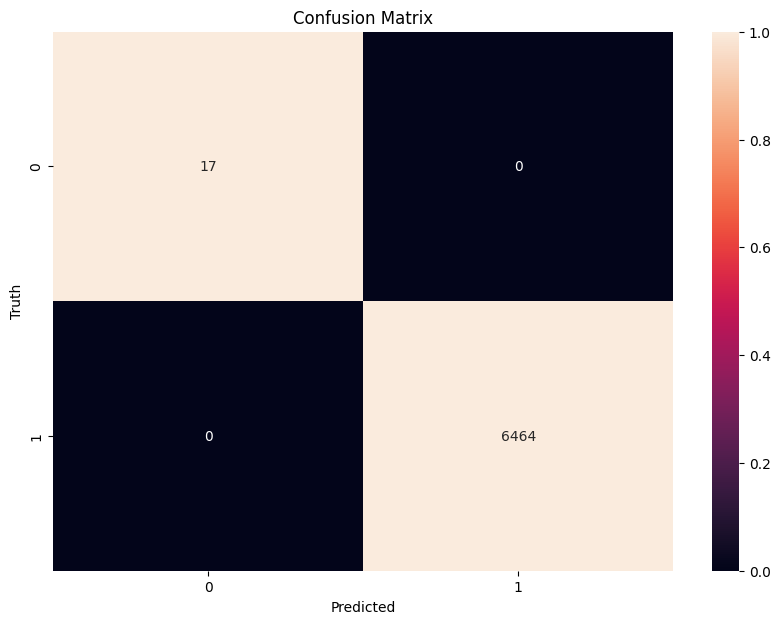

In [35]:
cm = confusion_matrix(y_test, y_pred)
cp = cm / cm.sum(axis=1)[:, np.newaxis] # Confusion Matrix Percentage
plt.figure(figsize=(10, 7))
sns.heatmap(cp, annot=cm, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

In [37]:
# from art.attacks.evasion import BoundaryAttack
# from art.estimators.classification import SklearnClassifier

# art_model = SklearnClassifier(model=clf)

# boundary_attack = BoundaryAttack(estimator=art_model, targeted=False)

# X_test_adv = boundary_attack.generate(X_test)

# y_pred_adv = clf.predict(X_test_adv)
# print("Rapport après attaque adversariale :")
# print(classification_report(y_test, y_pred_adv))

### One Class SVM Anomalies

In [38]:
X = df_svm.drop(columns=['Anomalie_Label'])
y = df_svm['Anomalie_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

1.0


In [39]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Anomalie       1.00      1.00      1.00        58
      Normal       1.00      1.00      1.00      9663

    accuracy                           1.00      9721
   macro avg       1.00      1.00      1.00      9721
weighted avg       1.00      1.00      1.00      9721



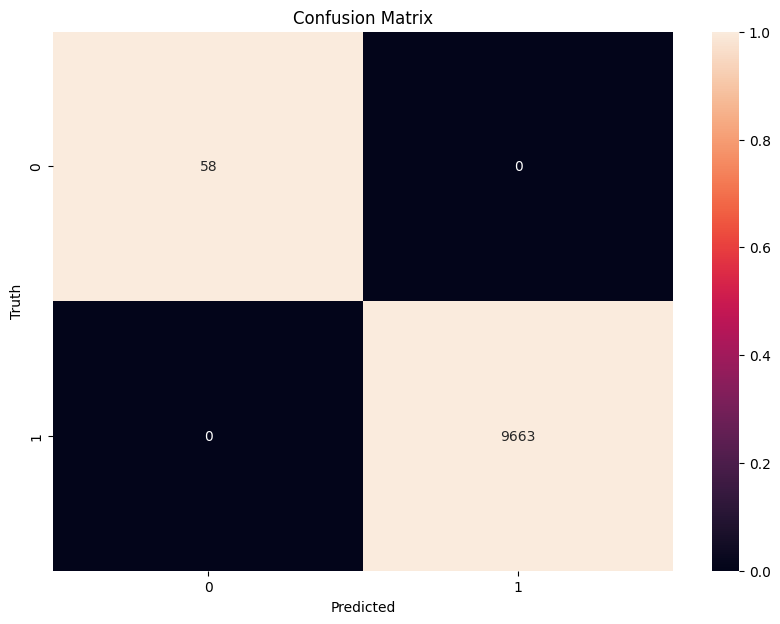

In [40]:
cm = confusion_matrix(y_test, y_pred)
cp = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 7))
sns.heatmap(cp, annot=cm, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()